<a href="https://colab.research.google.com/github/slvrsrfrrr/Machine-Learning/blob/main/LSTM_Time_Series_Forecast_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecast Part 2:

building on the initial ideas; but looking at 1D CNNs and GRU models, as well as multivariable models

# Data Processing

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


In [3]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
df.dtypes

Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

In [4]:
df = df[5::6]
#this means from the fifth interval, take every 6th value. the data we have is for every 10 minutes and we've got it to one entry per hour now.

In [5]:
df.index = pd.to_datetime(df['Date Time'],format ='%d.%m.%Y %H:%M:%S')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


**temperature Over Time**

<Axes: xlabel='Date Time'>

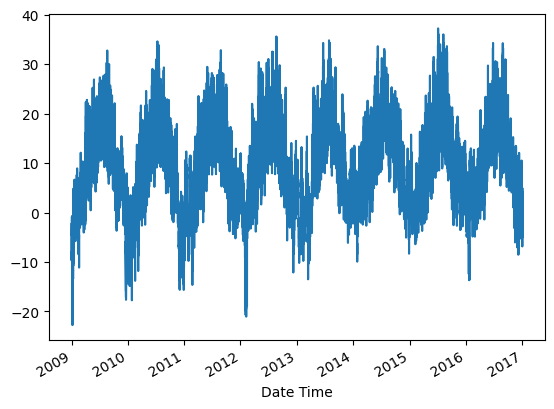

In [6]:
temp = df['T (degC)']
temp.plot()

we want to put the data into some kind of matrix. to explain, imagine you have the temperature over 5 hours and you want to predict the tempurature over the next hour. to get the next hour after that, youd basically bump the 5 initial values up by 1 and make the next prediction.
so that would look like


---

x= [[1][2][3][4][5]]  y=[[6]


---


   [[2][3][4][5][6]]    [[7]

each of the entries in the input matrix are also a list. it could be temp, pressure etc

In [7]:
def df_to_X_y(df,window_size=5):
  df_as_numpy = df.to_numpy()
  X=[]
  y=[]
  for i in range(len(df_as_numpy)-window_size):
    row = [[a] for a in df_as_numpy[i:i+window_size]]
    X.append(row)
    label = df_as_numpy[i+window_size]
    y.append(label)
  return np.array(X),np.array(y)

In [8]:
window_sizee = 5
X,y = df_to_X_y(temp,window_sizee)
X.shape,y.shape

((70086, 5, 1), (70086,))

# ***Train, Test, Validation Split***

In [9]:
X_train,y_train=X[:60000],y[:60000]
X_test,y_test=X[60000:65000],y[60000:65000]
X_val,y_val=X[65000:],y[65000:]


In [10]:
from tensorflow.keras import models

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# LSTM

In [12]:
model1= Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp = ModelCheckpoint('model1/',save_best_only=True)
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError()])

In [14]:
model1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,callbacks=[cp])

Epoch 1/10
1875/1875 [==============================] - 18s 8ms/step - loss: 28.0353 - root_mean_squared_error: 5.2948 - val_loss: 2.9643 - val_root_mean_squared_error: 1.7217
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 2.0909 - root_mean_squared_error: 1.4460 - val_loss: 1.0169 - val_root_mean_squared_error: 1.0084
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.9082 - root_mean_squared_error: 0.9530 - val_loss: 0.7369 - val_root_mean_squared_error: 0.8584
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.7292 - root_mean_squared_error: 0.8539 - val_loss: 0.6754 - val_root_mean_squared_error: 0.8218
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.6840 - root_mean_squared_error: 0.8271 - val_loss: 0.6340 - val_root_mean_squared_error: 0.7962
Epoch 6/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.6675 - root_mean_squared_error: 0.8170 - v

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [16]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

1875/1875 [==============================] - 5s 2ms/step


,Train Predictions,Actuals
0,-9.888686,-9.67
1,-9.711181,-9.17
2,-8.870103,-8.10
3,-7.395092,-7.66
4,-7.251565,-7.04
...,...,...
59995,6.070010,6.07
59996,7.276631,9.88
59997,12.121412,13.53
59998,16.021408,15.43


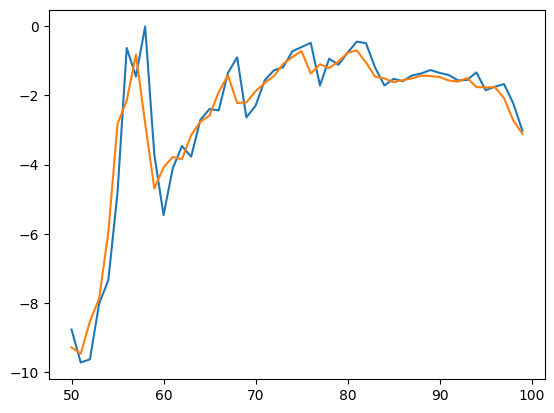

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

159/159 [==============================] - 1s 2ms/step


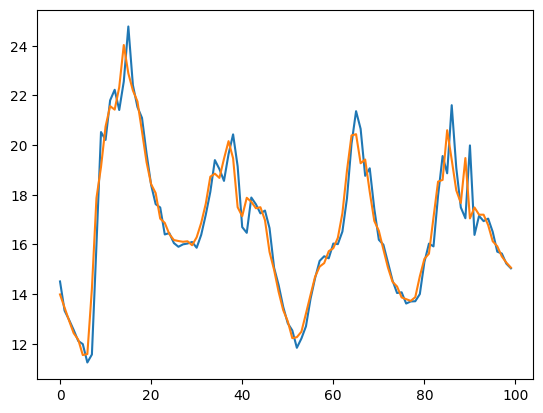

In [18]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

157/157 [==============================] - 1s 4ms/step


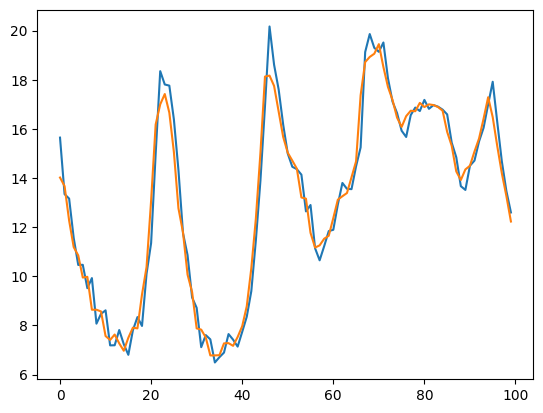

In [19]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [26]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

157/157 [==============================] - 0s 3ms/step


(      Predictions  Actuals
 0       15.645618    14.02
 1       13.344540    13.67
 2       13.163997    12.27
 3       11.566008    11.19
 4       10.462371    10.85
 ...           ...      ...
 4995    17.599339    18.27
 4996    17.544098    17.85
 4997    17.335732    16.65
 4998    15.989230    15.85
 4999    15.215982    15.09
 
 [5000 rows x 2 columns],
 0.4987714083299994)

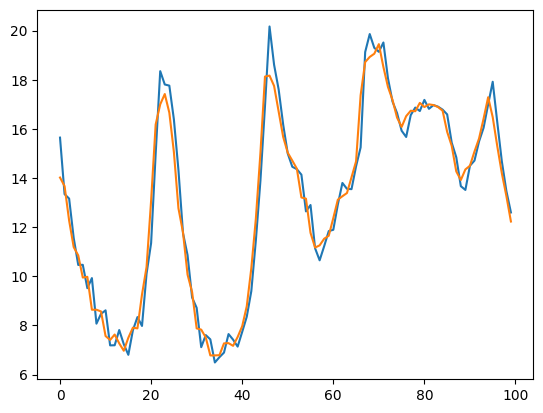

In [27]:
plot_predictions1(model1, X_test, y_test)

# CNN

In [28]:
model2= Sequential()
model2.add(InputLayer((5,1)))
model2.add(Conv1D(64,kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8,'relu'))
model2.add(Dense(1,'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


by using a 1d convolutional NN, we've reduced the number of parametres from around 17k to 2k

In [29]:
cp2 = ModelCheckpoint('model2/',save_best_only=True)
model2.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError()])

In [30]:
model2.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,callbacks=[cp2])

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 5.3123 - root_mean_squared_error: 2.3048 - val_loss: 1.7949 - val_root_mean_squared_error: 1.3398
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.2938 - root_mean_squared_error: 1.1374 - val_loss: 1.0486 - val_root_mean_squared_error: 1.0240
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8735 - root_mean_squared_error: 0.9346 - val_loss: 0.7628 - val_root_mean_squared_error: 0.8734
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7291 - root_mean_squared_error: 0.8539 - val_loss: 0.7758 - val_root_mean_squared_error: 0.8808
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6979 - root_mean_squared_error: 0.8354 - val_loss: 0.6719 - val_root_mean_squared_error: 0.8197
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6862 - root_mean_squared_error: 0.8284 - val_loss: 0

they have a similar validation loss, but the complixity of the model is significantly decreased.

# GRU

In [31]:
model3= Sequential()
model3.add(InputLayer((5,1)))
model3.add(GRU(64))
model3.add(Dense(8,'relu'))
model3.add(Dense(1,'linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


13k parametres, in between the LSTM and CNN

In [34]:
cp3 = ModelCheckpoint('model3/',save_best_only=True)
model3.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError()])

In [35]:
model3.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,callbacks=[cp3])

Epoch 1/10
1875/1875 [==============================] - 16s 7ms/step - loss: 63.1986 - root_mean_squared_error: 7.9498 - val_loss: 25.5315 - val_root_mean_squared_error: 5.0529
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 6.0990 - root_mean_squared_error: 2.4696 - val_loss: 3.9281 - val_root_mean_squared_error: 1.9819
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 1.5062 - root_mean_squared_error: 1.2273 - val_loss: 1.2631 - val_root_mean_squared_error: 1.1239
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.8479 - root_mean_squared_error: 0.9208 - val_loss: 0.7974 - val_root_mean_squared_error: 0.8930
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.7076 - root_mean_squared_error: 0.8412 - val_loss: 0.6647 - val_root_mean_squared_error: 0.8153
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6723 - root_mean_squared_error: 0.8200 - val

# Multiple Variables

using extra variables as well as temperature, and also comverting the timestamp into some usable features as well

In [37]:
temp_df= pd.DataFrame({'Temperature':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df.head()

,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09


In [40]:
day = 60*24*60
year = 365.2425*day

temp_df['Day sin']= np.sin(temp_df['Seconds']*(2*np.pi / day))
temp_df['Day cos']= np.cos(temp_df['Seconds']*(2*np.pi / day))
temp_df['Year sin']= np.sin(temp_df['Seconds']*(2*np.pi / year))
temp_df['Year cos']= np.cos(temp_df['Seconds']*(2*np.pi / year))

temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917


In [42]:
temp_df = temp_df.drop('Seconds',axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917


this was done because temperature is periodic. If you take midday in december and midday in January, they should have a similar temperature value and an increasing seconds scale doesnt really account for that.

---
also, the time should be similar for december each year


In [43]:
def df_to_X_y2(df,window_size=6):
  df_as_numpy = df.to_numpy()
  X=[]
  y=[]
  for i in range(len(df_as_numpy)-window_size):
    row = [r for r in df_as_numpy[i:i+window_size]]
    X.append(row)
    label = df_as_numpy[i+window_size][0]
    y.append(label)
  return np.array(X),np.array(y)

In [45]:
X2,y2 = df_to_X_y2(temp_df)
X2.shape,y2.shape

((70085, 6, 5), (70085,))

In [46]:
X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

***preprocessing***

---
standardising the temperature


In [47]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:,:,0])

def preprocess(X):
  X[:,:,0]=(X[:,:,0]-temp_training_mean)/temp_training_std
  return X

In [ ]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

In [49]:
model4= Sequential()
model4.add(InputLayer((6,5)))
model4.add(LSTM(64))
model4.add(Dense(8,'relu'))
model4.add(Dense(1,'linear'))

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [51]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
1875/1875 [==============================] - 21s 10ms/step - loss: 30.4982 - root_mean_squared_error: 5.5225 - val_loss: 4.2031 - val_root_mean_squared_error: 2.0502
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.8117 - root_mean_squared_error: 2.1936 - val_loss: 2.0831 - val_root_mean_squared_error: 1.4433
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 1.9886 - root_mean_squared_error: 1.4102 - val_loss: 1.0130 - val_root_mean_squared_error: 1.0065
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 1.0470 - root_mean_squared_error: 1.0232 - val_loss: 0.7041 - val_root_mean_squared_error: 0.8391
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.7660 - root_mean_squared_error: 0.8752 - val_loss: 0.5411 - val_root_mean_squared_error: 0.7356
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.6199 - root_mean_squared_error: 0.7873 - val

159/159 [==============================] - 2s 7ms/step


(      Predictions  Actuals
 0       13.133652    13.46
 1       12.710509    12.93
 2       12.304838    12.43
 3       11.987522    12.17
 4       12.104655    11.55
 ...           ...      ...
 5080    -1.134647    -0.98
 5081    -1.548921    -1.40
 5082    -1.814307    -2.75
 5083    -3.158383    -2.89
 5084    -3.241379    -3.93
 
 [5085 rows x 2 columns],
 0.4742570602036707)

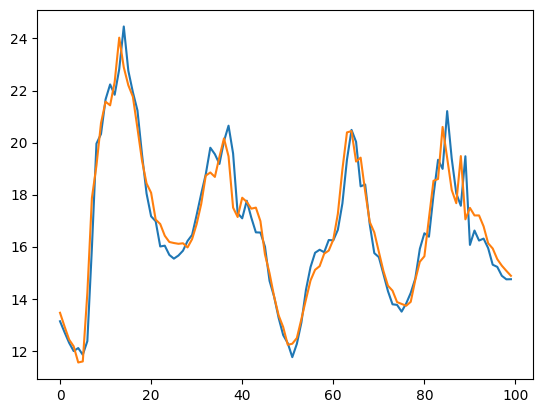

In [52]:
plot_predictions1(model4, X2_test, y2_test)

# Pressure

In [54]:
p_temp_df= pd.concat([df['p (mbar)'],temp_df], axis=1)
p_temp_df.head()


,p (mbar),Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,0.965926,0.258819,0.012916,0.999917


In [55]:
def df_to_X_y3(df,window_size=7):
  df_as_numpy = df.to_numpy()
  X=[]
  y=[]
  for i in range(len(df_as_numpy)-window_size):
    row = [r for r in df_as_numpy[i:i+window_size]]
    X.append(row)
    label = [df_as_numpy[i+window_size][0],df_as_numpy[i+window_size][1]]
    y.append(label)
  return np.array(X),np.array(y)

In [57]:
X3,y3 = df_to_X_y3(p_temp_df)
X3.shape,y3.shape

((70084, 7, 6), (70084, 2))

In [58]:
X3_train, y3_train = X3[:60000], y3[:60000]
X3_val, y3_val = X3[60000:65000], y3[60000:65000]
X3_test, y3_test = X3[65000:], y3[65000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((60000, 7, 6), (60000, 2), (5000, 7, 6), (5000, 2), (5084, 7, 6), (5084, 2))

In [59]:
p_training_mean3 = np.mean(X3_train[:, :, 0])
p_training_std3 = np.std(X3_train[:,:,0])

temp_training_mean3 = np.mean(X3_train[:, :, 1])
temp_training_std3 = np.std(X3_train[:, :, 1])

def preprocess3(X):
  X[:, :, 0] = (X[:, :, 0]-p_training_mean3)/p_training_std3
  X[:, :, 1] = (X[:, :, 1]-temp_training_mean3)/temp_training_std3

def preprocess_output(y):
  y[: ,0] = (y[:, 0]-p_training_mean3)/p_training_std3
  y[:, 1] = (y[:, 1]-temp_training_mean3)/temp_training_std3
  return y

In [60]:
preprocess3(X3_train)
preprocess3(X3_test)
preprocess3(X3_val)


In [61]:
preprocess_output(y3_train)
preprocess_output(y3_val)
preprocess_output(y3_test)

array([[-0.7934386 ,  0.41245076],
       [-0.76312281,  0.35368268],
       [-0.72189335,  0.32312327],
       ...,
       [ 1.48145784, -1.43051636],
       [ 1.41597574, -1.44697142],
       [ 1.35049365, -1.56920903]])

In [62]:
model5= Sequential()
model5.add(InputLayer((7,6)))
model5.add(LSTM(64))
model5.add(Dense(8,'relu'))
model5.add(Dense(2,'linear'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 2)                 18        
                                                                 
Total params: 18714 (73.10 KB)
Trainable params: 18714 (73.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [64]:
model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp5])

Epoch 1/10
1875/1875 [==============================] - 21s 9ms/step - loss: 0.1617 - root_mean_squared_error: 0.4021 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1813
Epoch 2/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0247 - root_mean_squared_error: 0.1570 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1279
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 6/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_

In [65]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
  p_actuals, temp_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])
  return df[start:end]

159/159 [==============================] - 1s 3ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,0.400409,0.412451,-0.780402,-0.793439
1,0.354306,0.353683,-0.772891,-0.763123
2,0.307183,0.323123,-0.743289,-0.721893
3,0.300574,0.250251,-0.694284,-0.652773
4,0.261730,0.254952,-0.606587,-0.652773
...,...,...,...,...
95,0.677910,0.716869,-0.406078,-0.416310
96,0.640390,0.687485,-0.408819,-0.399333
97,0.619837,0.663978,-0.393949,-0.399333
98,0.612217,0.641646,-0.388131,-0.400546


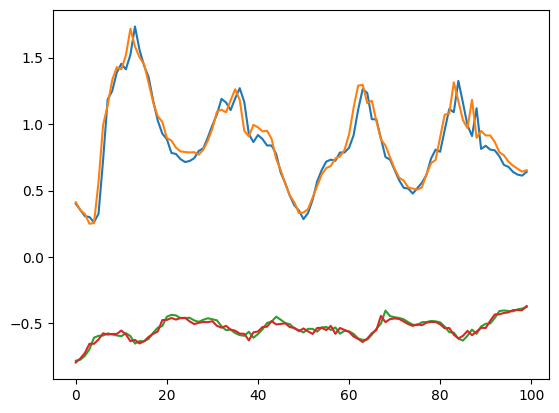

In [66]:
plot_predictions2(model5, X3_test, y3_test)

In [67]:
def postprocess_temp(arr):
  arr = (arr*temp_training_std3) + temp_training_mean3
  return arr

def postprocess_p(arr):
  arr = (arr*p_training_std3) + p_training_mean3
  return arr

In [68]:
def plot_predictions3(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = postprocess_p(predictions[:, 0]), postprocess_temp(predictions[:, 1])
  p_actuals, temp_actuals = postprocess_p(y[:, 0]), postprocess_temp(y[:, 1])
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])
  return df[start:end]

159/159 [==============================] - 1s 7ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,12.827548,12.93,982.537537,982.43
1,12.435307,12.43,982.599487,982.68
2,12.034377,12.17,982.843567,983.02
3,11.978150,11.55,983.247681,983.59
4,11.647665,11.59,983.970886,983.59
...,...,...,...,...
95,15.188534,15.52,985.624390,985.54
96,14.869314,15.27,985.601807,985.68
97,14.694444,15.07,985.724426,985.68
98,14.629615,14.88,985.772400,985.67


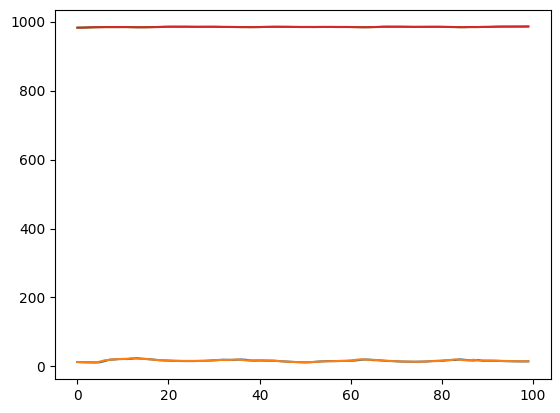

In [69]:
post_processed_df = plot_predictions3(model5, X3_test, y3_test)
post_processed_df

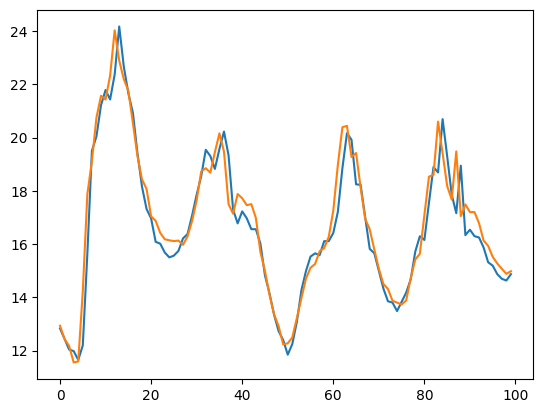

In [70]:
start, end = 0, 100
plt.plot(post_processed_df['Temperature Predictions'][start:end])
plt.plot(post_processed_df['Temperature Actuals'][start:end])

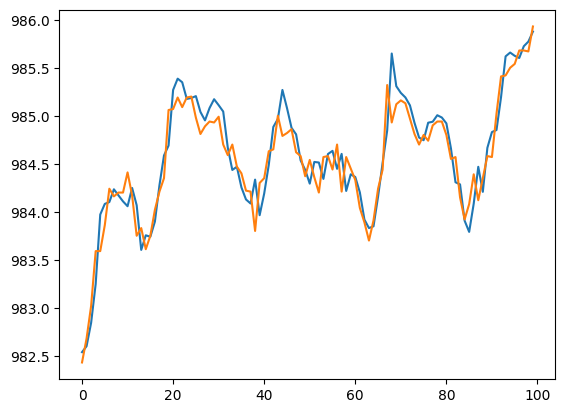

In [71]:
plt.plot(post_processed_df['Pressure Predictions'][start:end])
plt.plot(post_processed_df['Pressure Actuals'][start:end])